# Librerias

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Clasificación Multiclase 

## Modelo EfficientNetB0

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB0-dataBalanceada')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar y configurar el modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


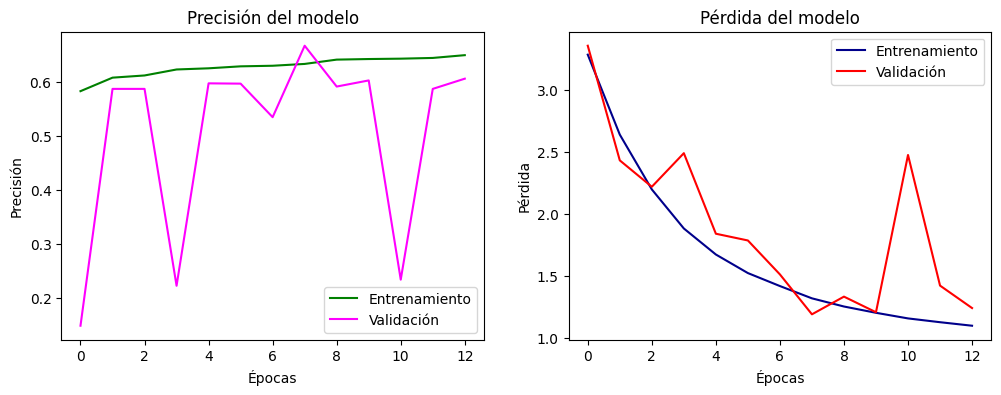

In [ ]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()


# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB4

In [2]:
# Inicializar Weights & Biases 
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='EfficientNetB4-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


NameError: name 'history' is not defined

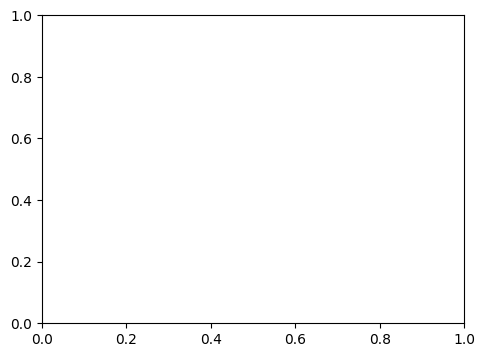

In [7]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo EfficientNetB5

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='EfficientNetB5')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # Importante para evaluaciones
)

# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


NameError: name 'history' is not defined

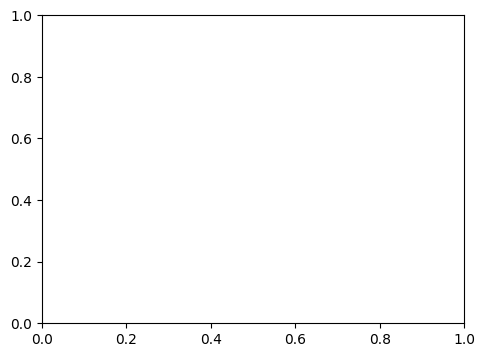

In [8]:
# Establecer una figura para alojar ambos gráficos
plt.figure(figsize=(12, 4))  # Ajusta el tamaño total de la figura

# Gráfica de precisión
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')  # color verde para entrenamiento
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')  # color magenta para validación
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')  # color azul oscuro para entrenamiento
plt.plot(history.history['val_loss'], label='Validación', color='red')  # color rojo para validación
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV2

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV2')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


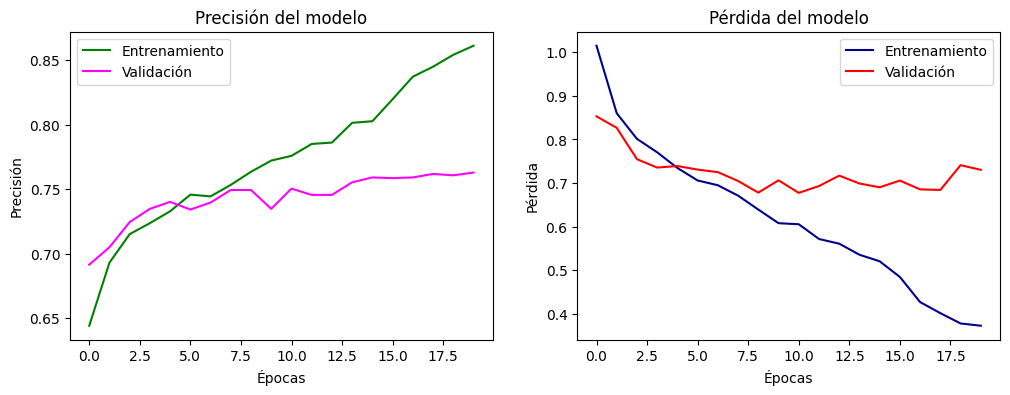

In [144]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo MobileNetV3

In [ ]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='MobileNetV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_mobilenet.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

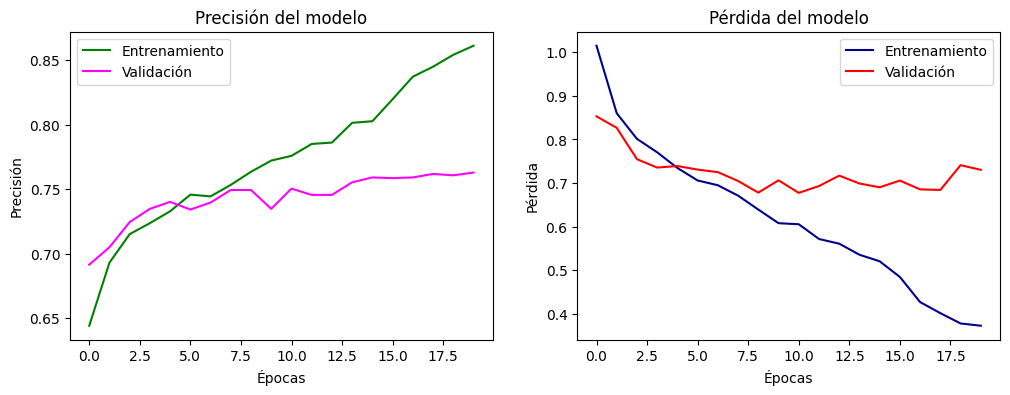

In [ ]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo InceptionV3

In [8]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', name='InceptionV3')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 requiere imágenes de 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_inception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

Found 7378 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


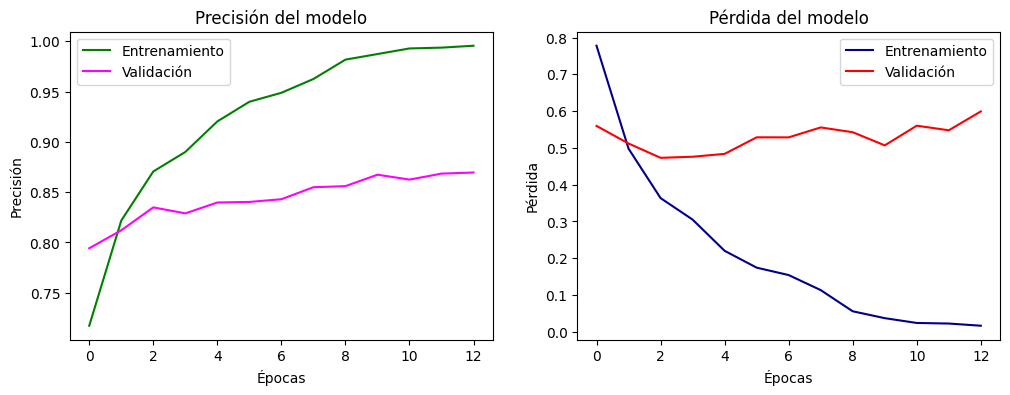

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

## Modelo Xception

In [2]:
# Inicializar WandB
wandb.login()
wandb.init(project='clasificacion-celulas', entity='tp3-td6', name='Xception-balanceado')

# Configuración de directorios y generadores de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'
IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception también requiere 299x299
BATCH_SIZE = 32

# Generador de datos con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  
    width_shift_range=0.05,  
    height_shift_range=0.05,  
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Importar y Definir el Modelo Xception
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_xception.h5', monitor='val_loss', save_best_only=True, verbose=1)
wandb_callback = WandbCallback(save_model=False)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, wandb_callback]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

# Loggear los resultados en WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


Found 8097 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


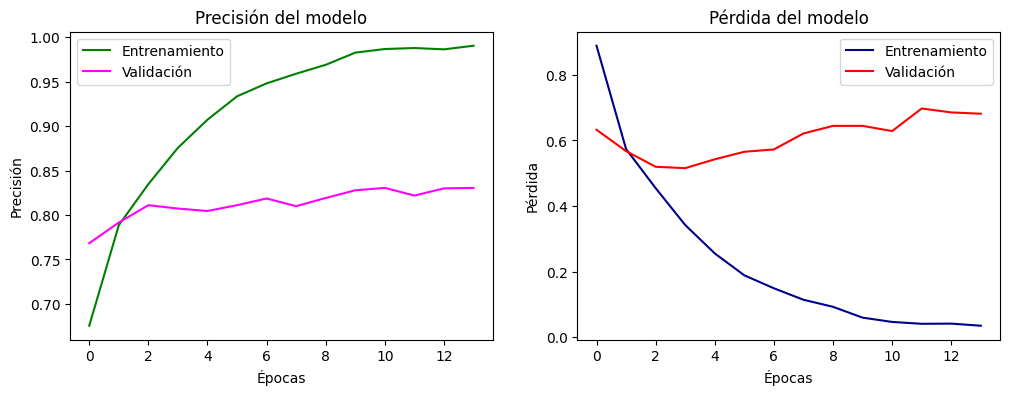

In [6]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', color='green')
plt.plot(history.history['val_accuracy'], label='Validación', color='magenta')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', color='darkblue')
plt.plot(history.history['val_loss'], label='Validación', color='red')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

# Generar predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# Clasificación Binaria -> clasificación luego multiclase

## Clasificación Binaria

### generación de datos

In [613]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

In [669]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import shutil

# Directorio de las imágenes
data_dir = 'crops_90x90'

# Directorios de salida para las imágenes
output_dir = 'crops_90x90_2clases'  # Directorio base para las nuevas carpetas
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Crear las carpetas si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subcarpetas adicionales para "lesion" y "no lesion"
lesion_subfolders = ['1_lesion', '0_no_lesion']
for subfolder in lesion_subfolders:
    os.makedirs(os.path.join(train_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, subfolder), exist_ok=True)

# Configuración del generador de imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar todas las imágenes y etiquetas
all_images_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='categorical',  # Multiclase inicialmente
    classes=['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC'],
    shuffle=False
)

# Obtener los nombres de archivos y etiquetas
filepaths = all_images_generator.filepaths
labels = all_images_generator.classes

# Convertir las etiquetas multiclase en binarias basado en el índice de 'Negative'
negative_index = all_images_generator.class_indices['Negative']
has_lesion = np.where(labels == negative_index, 0, 1)  # 0: Negative (sin lesión), 1: Otras clases (con lesión)

# Función para generar un dataframe desde los archivos seleccionados con una columna adicional "has_lesion"
def create_dataframe_with_lesion(files, labels, has_lesion_str):
    df = pd.DataFrame({'filename': files, 'label': labels, 'has_lesion': has_lesion_str})
    return df

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
train_files, test_files, train_labels, test_labels, train_lesion, test_lesion = train_test_split(
    filepaths, labels, has_lesion.astype(str), test_size=0.30, stratify=labels, random_state=42
)
val_files, test_files, val_labels, test_labels, val_lesion, test_lesion = train_test_split(
    test_files, test_labels, test_lesion, test_size=0.5, stratify=test_labels, random_state=42
)

# Función para copiar imágenes a las carpetas correspondientes
def copy_images(filepaths, lesions, dest_dir):
    for filepath, lesion in zip(filepaths, lesions):
        if lesion == '0':  # Sin lesión (Negative)
            dest_subfolder = '0_no_lesion'
        else:  # Con lesión (todas las demás clases)
            dest_subfolder = '1_lesion'
        
        # Obtener el nombre de la subcarpeta (lesion/no lesion)
        dest_path = os.path.join(dest_dir, dest_subfolder)
        shutil.copy(filepath, dest_path)  # Copiar la imagen

# Copiar imágenes a las carpetas correspondientes en función de si tienen lesión o no
copy_images(train_files, train_lesion, train_dir)
copy_images(val_files, val_lesion, val_dir)
copy_images(test_files, test_lesion, test_dir)

# Imprimir el resultado
print(f"Total de imágenes copiadas a entrenamiento: {len(train_files)}")
print(f"Total de imágenes copiadas a validación: {len(val_files)}")
print(f"Total de imágenes copiadas a prueba: {len(test_files)}")

Found 11534 images belonging to 6 classes.
Total de imágenes copiadas a entrenamiento: 8073
Total de imágenes copiadas a validación: 1730
Total de imágenes copiadas a prueba: 1731


#### Grafico de la distribución de las clases

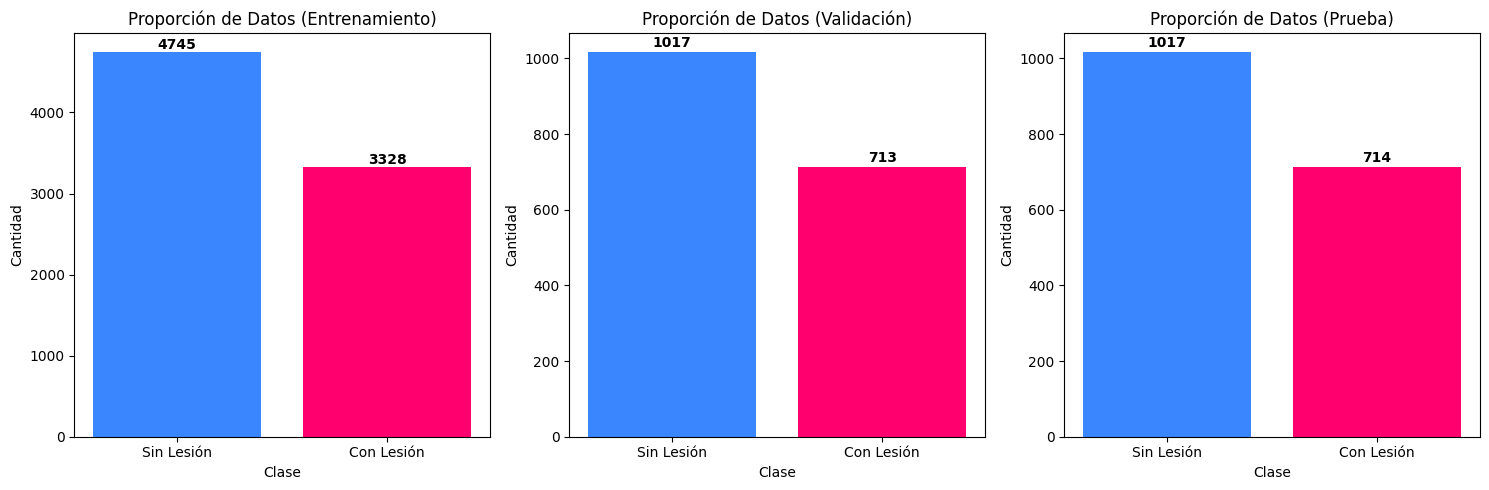

In [670]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en las carpetas "lesion" y "no lesion"
def count_images_in_folders(folder_path):
    lesion_count = len(os.listdir(os.path.join(folder_path, '1_lesion')))
    no_lesion_count = len(os.listdir(os.path.join(folder_path, '0_no_lesion')))
    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Aumentación de Imagenes de la clase minoritaria

In [584]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

# Configuración del generador de imágenes con augmentation para la clase minoritaria
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotaciones leves para preservar la estructura del núcleo
    horizontal_flip=True,   # Flip horizontal
    vertical_flip=True,     # Flip vertical
    brightness_range=[0.8, 1.2],  # Cambios en el brillo para simular variaciones de iluminación
    fill_mode='nearest'     # Relleno de los bordes tras los cambios de transformación
)

# Definir directorio de la clase con lesión
train_dir = 'crops_90x90_2clases/train/1_lesion'
output_dir = 'crops_90x90_2clases/train/1_lesion'  # Directorio para guardar imágenes augmentadas

# Crear la carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Cargar imágenes de la clase con lesión
lesion_generator = augmentation.flow_from_directory(
    'crops_90x90_2clases/train',  # Directorio raíz
    target_size=(90, 90),         # Tamaño de las imágenes
    batch_size=1,                 # Procesar una imagen por vez para guardarla
    class_mode='binary',
    classes=['1_lesion'],         # Solo tomar la clase con lesión
    shuffle=True
)

# Número de imágenes augmentadas que quieres generar
num_images_to_generate = 1000  # Cambia este valor según cuántas imágenes quieras generar

# Contador de imágenes generadas
generated_images = 0

# Generar y guardar imágenes augmentadas
for i in range(num_images_to_generate):
    if generated_images >= num_images_to_generate:
        break
    
    # Generar la imagen augmentada
    augmented_image = next(lesion_generator)[0]  # Primera imagen del batch
    
    # Eliminar la dimensión de batch
    augmented_image = np.squeeze(augmented_image, axis=0)
    
    # Convertir la imagen de nuevo a formato original (sin normalización)
    augmented_image = augmented_image * 255  # Deshacer el rescale aplicado por ImageDataGenerator
    img = array_to_img(augmented_image)  # Convertir a imagen PIL para guardar

    # Guardar la imagen augmentada
    img.save(os.path.join(output_dir, f'lesion_augmented_{generated_images}.png'))
    
    # Incrementar el contador
    generated_images += 1

print(f'{generated_images} imágenes augmentadas guardadas en {output_dir}')

Found 3328 images belonging to 1 classes.
1000 imágenes augmentadas guardadas en crops_90x90_2clases/train/1_lesion


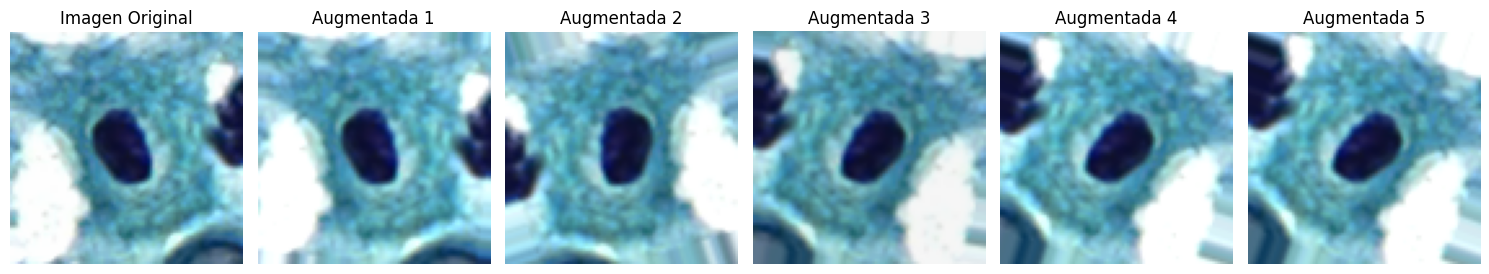

In [585]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Configuración del generador de imágenes con augmentation para la clase minoritaria
augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotaciones leves para preservar la estructura del núcleo
    horizontal_flip=True,   # Flip horizontal
    vertical_flip=True,     # Flip vertical
    brightness_range=[0.8, 1.2],  # Cambios en el brillo para simular variaciones de iluminación
    fill_mode='nearest'     # Relleno de los bordes tras los cambios de transformación
)

# Ruta de la carpeta con las imágenes originales (clase con lesión)
train_dir = 'crops_90x90_2clases/train/1_lesion'

# Cargar una imagen original para augmentación (cambia el nombre si es necesario)
img_path = os.path.join(train_dir, 'ee5338ab73b4db0c88f9e9dc98aca68e_LSIL_34.png')  # Cambia 'tu_imagen.jpg' por una imagen real en tu carpeta
original_image = load_img(img_path, target_size=(90, 90))  # Cargar la imagen original
original_image_array = img_to_array(original_image)  # Convertir la imagen a array

# Expande dimensiones para que coincida con el input del generador (batch size)
original_image_array = np.expand_dims(original_image_array, axis=0)

# Generador de imágenes augmentadas a partir de la imagen original
augment_generator = augmentation.flow(original_image_array, batch_size=1)

# Número de imágenes augmentadas a generar y mostrar
num_augmented_images = 5

# Visualizar la imagen original y 5 imágenes augmentadas
fig, ax = plt.subplots(1, num_augmented_images + 1, figsize=(15, 5))  # +1 para incluir la imagen original

# Mostrar la imagen original en el primer subplot
ax[0].imshow(original_image_array[0].astype('uint8'))
ax[0].set_title('Imagen Original')
ax[0].axis('off')

# Generar y mostrar las imágenes augmentadas
for i in range(1, num_augmented_images + 1):
    # Generar la imagen augmentada
    augmented_image = next(augment_generator)[0]  # Primera imagen del batch
    
    # Mostrar la imagen augmentada
    ax[i].imshow(augmented_image)
    ax[i].set_title(f'Augmentada {i}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

#### Grafico con la distribución de las clases luego de la aumentación

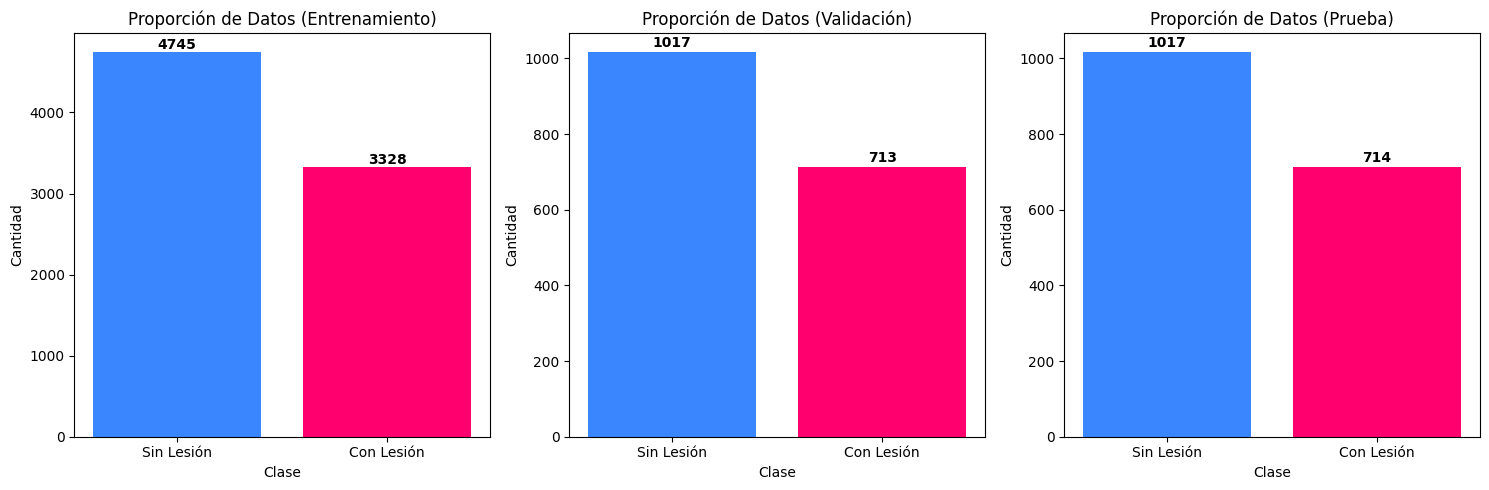

In [616]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Función para contar imágenes en las carpetas "lesion" y "no lesion"
def count_images_in_folders(folder_path):
    lesion_count = len(os.listdir(os.path.join(folder_path, '1_lesion')))
    no_lesion_count = len(os.listdir(os.path.join(folder_path, '0_no_lesion')))
    return lesion_count, no_lesion_count

# Función para crear gráficos de barras para las proporciones
def plot_proportion_subplot(ax, lesion_count, no_lesion_count, title):
    # Crear el gráfico de barras en el subplot
    ax.bar(['Sin Lesión', 'Con Lesión'], [no_lesion_count, lesion_count], color=['#3A86FF', '#FF006E'])
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad en las barras
    ax.text(0, no_lesion_count + 5, str(no_lesion_count), ha='center', va='bottom', fontweight='bold')
    ax.text(1, lesion_count + 5, str(lesion_count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento, validación y prueba
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Contar las imágenes en cada conjunto
train_lesion_count, train_no_lesion_count = count_images_in_folders(train_dir)
val_lesion_count, val_no_lesion_count = count_images_in_folders(val_dir)
test_lesion_count, test_no_lesion_count = count_images_in_folders(test_dir)

# Crear una figura con tres subplots (uno para cada conjunto)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas, tamaño ajustado

# Crear gráficos en cada subplot
plot_proportion_subplot(axes[0], train_lesion_count, train_no_lesion_count, 'Proporción de Datos (Entrenamiento)')
plot_proportion_subplot(axes[1], val_lesion_count, val_no_lesion_count, 'Proporción de Datos (Validación)')
plot_proportion_subplot(axes[2], test_lesion_count, test_no_lesion_count, 'Proporción de Datos (Prueba)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Generación de los datos de entrenamiento, validación y test

In [671]:
# Directorios de las carpetas binarias
train_dir = 'crops_90x90_2clases/train'
val_dir = 'crops_90x90_2clases/val'
test_dir = 'crops_90x90_2clases/test'

# Crear generadores de imágenes para cargar los datos desde las carpetas binarizadas
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde los directorios binarios para entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(90, 90),  # Ajustar si necesitas cambiar el tamaño
    batch_size=32,
    class_mode='binary',  # Clasificación binaria
    shuffle=True 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(90, 90),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Asegurar que el orden sea consistente
)


Found 8073 images belonging to 2 classes.
Found 1730 images belonging to 2 classes.
Found 1731 images belonging to 2 classes.


### MovileNetV2

In [774]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.3),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/30
253/253 [==============================] - 15s 52ms/step - loss: 0.7353 - accuracy: 0.6190 - precision: 0.5283 - recall: 0.7070 - auc: 0.6786 - f1_score: 0.5838 - val_loss: 0.8245 - val_accuracy: 0.6306 - val_precision: 0.8700 - val_recall: 0.1220 - val_auc: 0.8156 - val_f1_score: 0.5837
Epoch 2/30
253/253 [==============================] - 12s 48ms/step - loss: 0.5302 - accuracy: 0.7354 - precision: 0.6750 - recall: 0.6908 - auc: 0.8118 - f1_score: 0.5838 - val_loss: 0.6503 - val_accuracy: 0.6850 - val_precision: 0.8529 - val_recall: 0.2847 - val_auc: 0.8650 - val_f1_score: 0.5837
Epoch 3/30
253/253 [==============================] - 13s 51ms/step - loss: 0.4569 - accuracy: 0.7808 - precision: 0.7332 - recall: 0.7359 - auc: 0.8625 - f1_score: 0.5838 - val_loss: 0.5416 - val_accuracy: 0.7306 - val_precision: 0.8731 - val_recall: 0.4053 - val_auc: 0.8832 - val_f1_score: 0.5837
Epoch 4/30
253/253 [==============================] - 13s 50ms/step - loss: 0.4191 - accuracy: 0.803

#### Evaluación

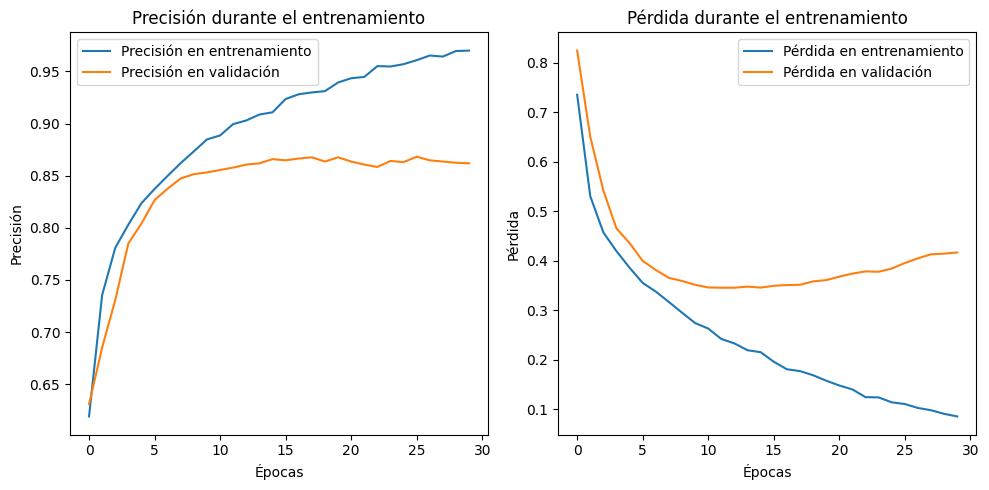

In [776]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [777]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 2s 31ms/step - loss: 0.3656 - accuracy: 0.8694 - precision: 0.8486 - recall: 0.8319 - auc: 0.9389 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.36556413769721985
accuracy en el conjunto de prueba: 0.8694396018981934
Precision en el conjunto de prueba: 0.8485714197158813
Recall en el conjunto de prueba: 0.831932783126831
AUC en el conjunto de prueba: 0.9389020800590515
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 2s 29ms/step


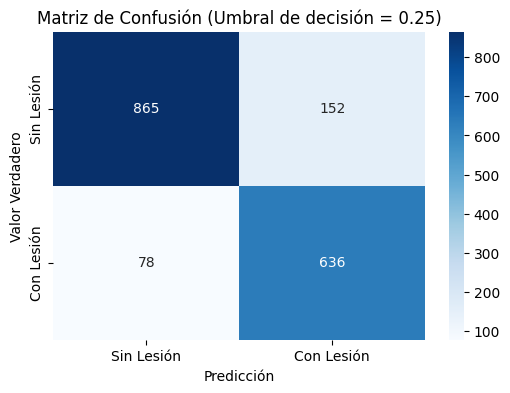

Recall (con umbral = 0.25): 0.8907563025210085
Precisión (con umbral = 0.25): 0.8071065989847716


In [784]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el nuevo umbral de decisión
threshold = 0.25  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 2s 30ms/step


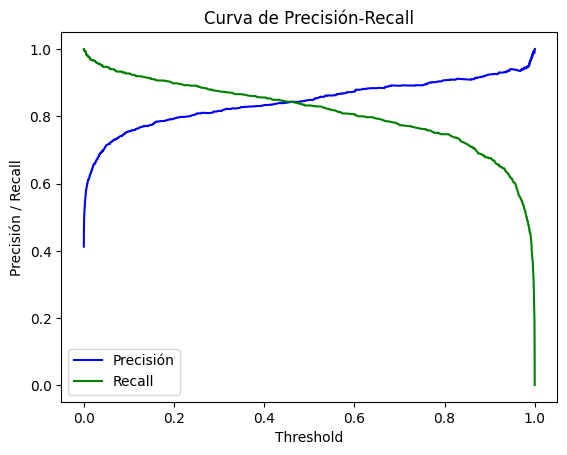

In [779]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

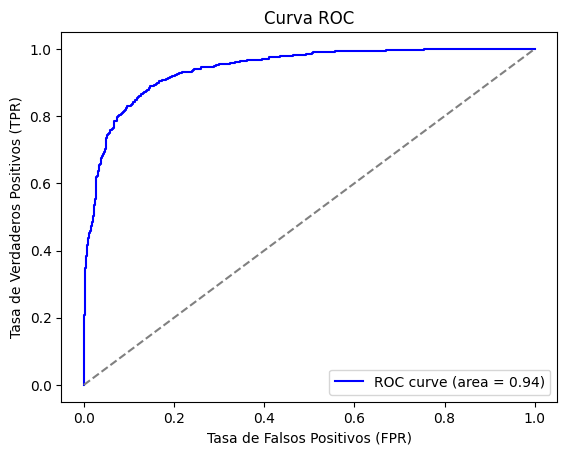

In [780]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [782]:
# Ajustar el umbral de decisión
new_threshold = 0.5
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8485714285714285
Recall: 0.8319327731092437
F1-Score: 0.8401697312588402
AUC: 0.9411709619934503


In [783]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 2s 29ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.25
Mejor F1-score: 0.8468708388814913


### MobileNetV3

In [765]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Cargar MobileNetV2 preentrenado en ImageNet, sin la capa superior
base_model = MobileNetV3Small(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(54, activation='relu'),
    layers.Dropout(0.3),  # Dropout con un 30% de desactivación de neuronas
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Entrenar el modelo usando los generadores de imágenes
history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=10,
    validation_data=val_generator,  # Generador para los datos de validación
)

Epoch 1/10
253/253 [==============================] - 9s 29ms/step - loss: 0.6345 - accuracy: 0.6460 - precision: 0.5897 - recall: 0.4642 - auc: 0.6926 - f1_score: 0.5838 - val_loss: 0.7025 - val_accuracy: 0.5879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3553 - val_f1_score: 0.5837
Epoch 2/10
253/253 [==============================] - 6s 25ms/step - loss: 0.5537 - accuracy: 0.7040 - precision: 0.6517 - recall: 0.6055 - auc: 0.7773 - f1_score: 0.5838 - val_loss: 0.7214 - val_accuracy: 0.5879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5488 - val_f1_score: 0.5837
Epoch 3/10
253/253 [==============================] - 7s 26ms/step - loss: 0.5250 - accuracy: 0.7324 - precision: 0.6760 - recall: 0.6740 - auc: 0.8044 - f1_score: 0.5838 - val_loss: 0.7380 - val_accuracy: 0.5879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6515 - val_f1_score: 0.5837
Epoch 4/10
253/253 [==============================] - 8s 31ms/step - loss: 0.50

#### Evaluación

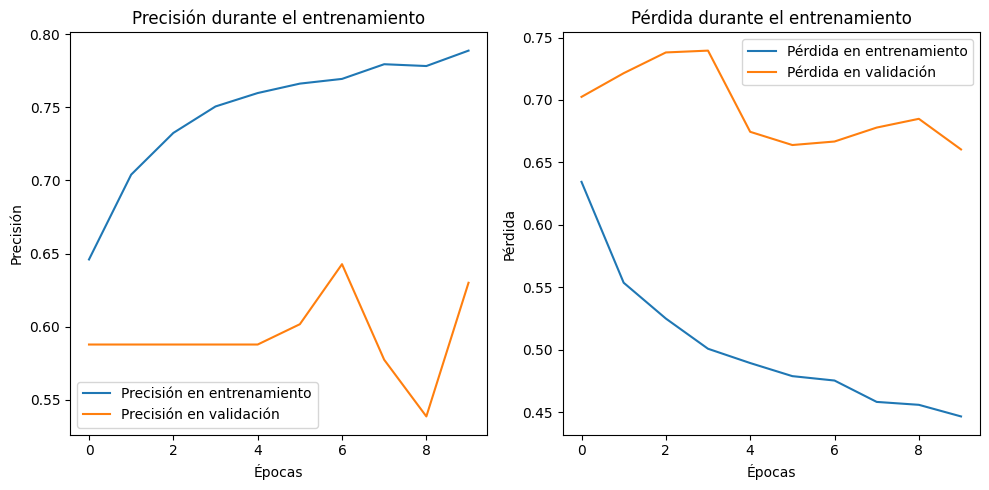

In [766]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [767]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 1s 21ms/step - loss: 0.6648 - accuracy: 0.6210 - precision: 0.5302 - recall: 0.7129 - auc: 0.6807 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.6648081541061401
accuracy en el conjunto de prueba: 0.6210283041000366
Precision en el conjunto de prueba: 0.5302083492279053
Recall en el conjunto de prueba: 0.7128851413726807
AUC en el conjunto de prueba: 0.6807342767715454
F1-Score en el conjunto de prueba: [0.58404905]


**Matriz de confusión**

55/55 [==============================] - 2s 27ms/step


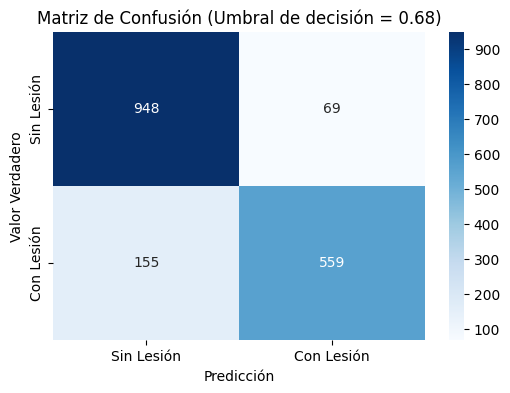

Recall (con umbral = 0.68): 0.7829131652661064
Precisión (con umbral = 0.68): 0.8901273885350318


In [775]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el nuevo umbral de decisión
threshold = 0.68  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 1s 24ms/step


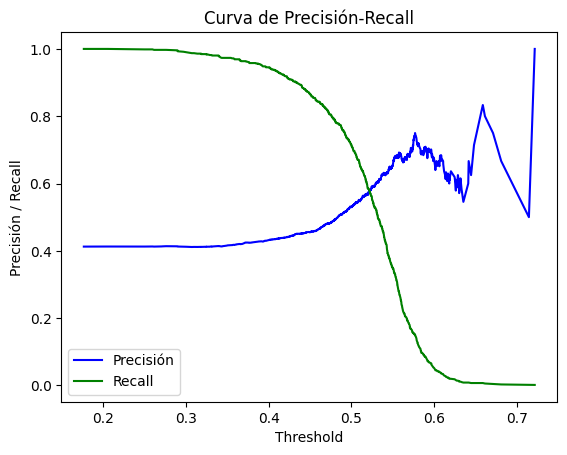

In [769]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

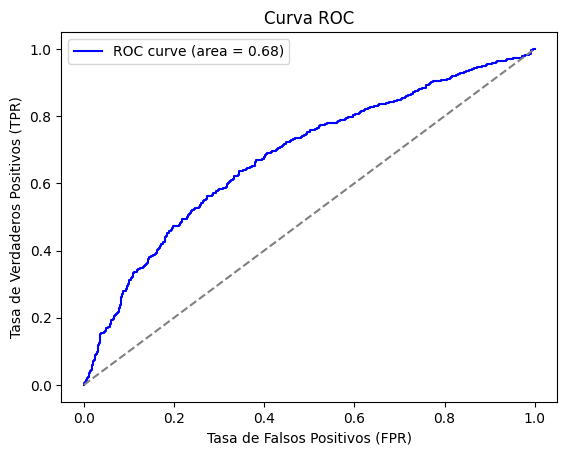

In [770]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [771]:
# Obtener las probabilidades predichas (no las clases binarias)
y_pred_prob = model.predict(test_generator)

# Generar las etiquetas verdaderas
y_true = test_generator.classes

# Calcular la curva ROC y el AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f'Área bajo la curva ROC: {roc_auc}')

# Área bajo la curva ROC: 0.5106949367751034

55/55 [==============================] - 1s 22ms/step
Área bajo la curva ROC: 0.6811694195869105


In [772]:
# Ajustar el umbral de decisión
new_threshold = 0.5
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

# Precisión: 0.43768545994065283
# Recall: 0.41316526610644255
# F1-Score: 0.42507204610951005
# AUC: 0.5106949367751034

Precisión: 0.5302083333333333
Recall: 0.7128851540616247
F1-Score: 0.6081242532855435
AUC: 0.6811694195869105


In [773]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 1s 19ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.49
Mejor F1-score: 0.6112994350282487


### ResNet

In [785]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

# Cargar ResNet50 preentrenado en ImageNet, sin la capa superior
base_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Crear el modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Incrementar el dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar algunas capas del modelo base para ajustar los pesos
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Ajusta el número de capas descongeladas si es necesario
    layer.trainable = False

# Recompilar el modelo con la versión legacy del optimizador Adam y una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=1e-5),  # Tasa de aprendizaje baja
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.F1Score(name='f1_score')]) 

# Aplicar class_weight para manejar el desbalanceo de clases
class_weight = {0: 1., 1: 3.5}  # Dar más peso a la clase con "lesión"

history = model.fit(
    train_generator,  # Generador para los datos de entrenamiento
    epochs=30,
    validation_data=val_generator,
)

Epoch 1/30
253/253 [==============================] - 84s 325ms/step - loss: 0.4925 - accuracy: 0.7551 - precision: 0.7075 - recall: 0.6920 - auc: 0.8330 - f1_score: 0.5838 - val_loss: 0.6210 - val_accuracy: 0.6387 - val_precision: 0.5357 - val_recall: 0.9257 - val_auc: 0.8280 - val_f1_score: 0.5837
Epoch 2/30
253/253 [==============================] - 81s 321ms/step - loss: 0.4327 - accuracy: 0.7983 - precision: 0.7549 - recall: 0.7563 - auc: 0.8765 - f1_score: 0.5838 - val_loss: 0.4052 - val_accuracy: 0.8197 - val_precision: 0.8463 - val_recall: 0.6872 - val_auc: 0.9006 - val_f1_score: 0.5837
Epoch 3/30
253/253 [==============================] - 88s 349ms/step - loss: 0.4170 - accuracy: 0.8117 - precision: 0.7739 - recall: 0.7674 - auc: 0.8859 - f1_score: 0.5838 - val_loss: 0.4363 - val_accuracy: 0.7931 - val_precision: 0.8884 - val_recall: 0.5694 - val_auc: 0.9034 - val_f1_score: 0.5837
Epoch 4/30
253/253 [==============================] - 83s 330ms/step - loss: 0.4051 - accuracy: 0

#### Evaluación

In [787]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 8s 150ms/step - loss: 0.5589 - accuracy: 0.7880 - precision: 0.8505 - recall: 0.5896 - auc: 0.8801 - f1_score: 0.5840
Pérdida en el conjunto de prueba: 0.5589182376861572
accuracy en el conjunto de prueba: 0.7879838347434998
Precision en el conjunto de prueba: 0.8505050539970398
Recall en el conjunto de prueba: 0.5896358489990234
AUC en el conjunto de prueba: 0.8801308870315552
F1-Score en el conjunto de prueba: [0.58404905]


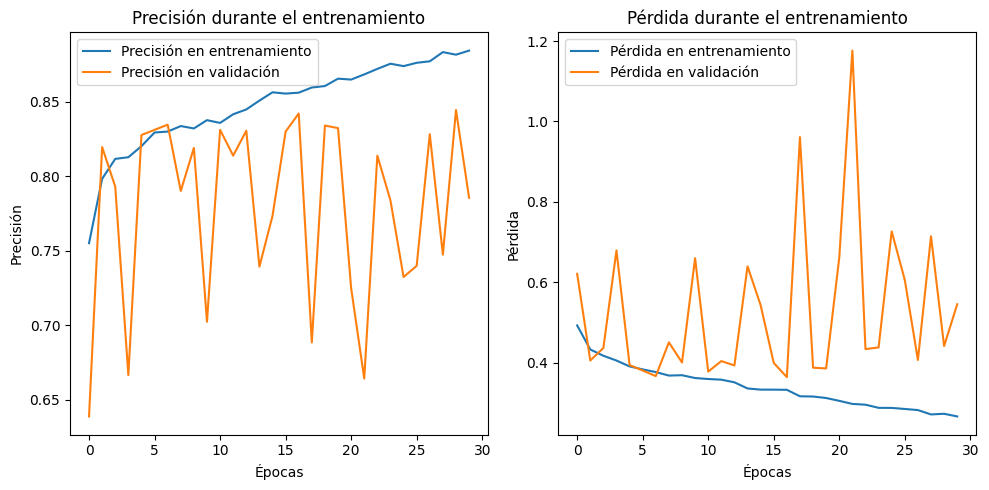

In [788]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

**Matriz de confusión**

55/55 [==============================] - 9s 160ms/step


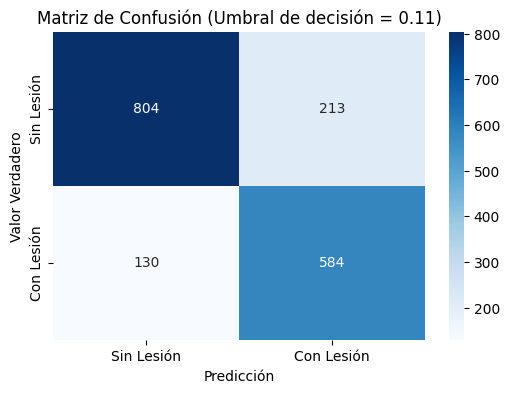

Recall (con umbral = 0.11): 0.8179271708683473
Precisión (con umbral = 0.11): 0.7327478042659975


In [793]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Definir el nuevo umbral de decisión
threshold = 0.11  # Ajusta este valor (ej. 0.3) para mejorar el recall

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Convertir las probabilidades a etiquetas binarias basadas en el umbral definido
y_pred = (y_pred_proba > threshold).astype(int)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegurar que y_true tenga el mismo tamaño que y_pred

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 8s 152ms/step


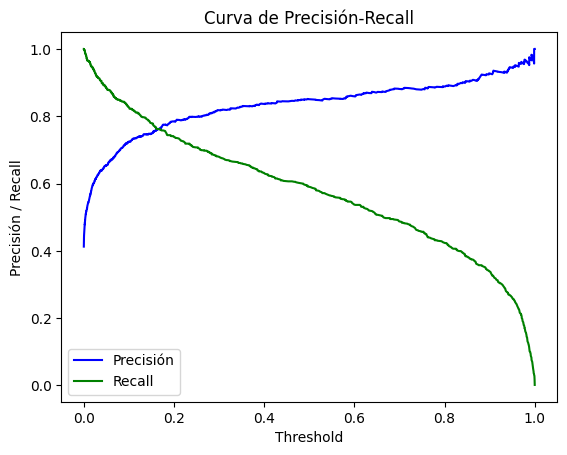

In [790]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

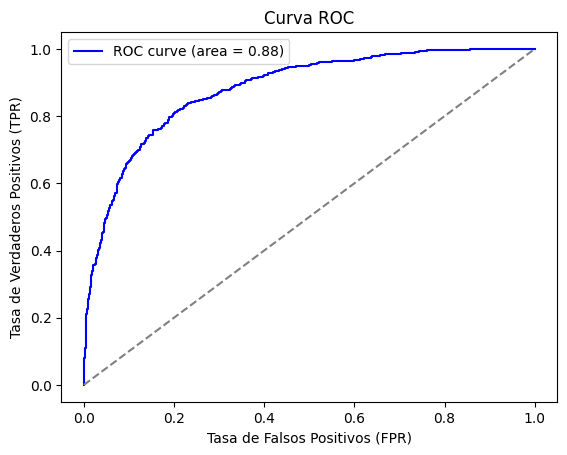

In [791]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [792]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

55/55 [==============================] - 9s 170ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.11
Mejor F1-score: 0.7729980145598941


### EfficientNetB0

In [823]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB0(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 3.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/30
253/253 [==============================] - 22s 77ms/step - loss: 1.3357 - accuracy: 0.4252 - precision: 0.4123 - recall: 0.9261 - auc: 0.5103 - f1_score: 0.5103 - val_loss: 0.8476 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.4950 - val_f1_score: 0.4950 - lr: 1.0000e-04
Epoch 2/30
253/253 [==============================] - 18s 71ms/step - loss: 1.2852 - accuracy: 0.4146 - precision: 0.4109 - recall: 0.9684 - auc: 0.5287 - f1_score: 0.5287 - val_loss: 0.8796 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7397 - val_f1_score: 0.7397 - lr: 1.0000e-04
Epoch 3/30
253/253 [==============================] - 18s 72ms/step - loss: 1.2630 - accuracy: 0.4219 - precision: 0.4147 - recall: 0.9775 - auc: 0.5591 - f1_score: 0.5591 - val_loss: 0.8501 - val_accuracy: 0.4121 - val_precision: 0.4121 - val_recall: 1.0000 - val_auc: 0.7839 - val_f1_score: 0.7839 - lr: 1.0000e-04
Epoch 4/30
253/253 [=============================

#### Evaluación

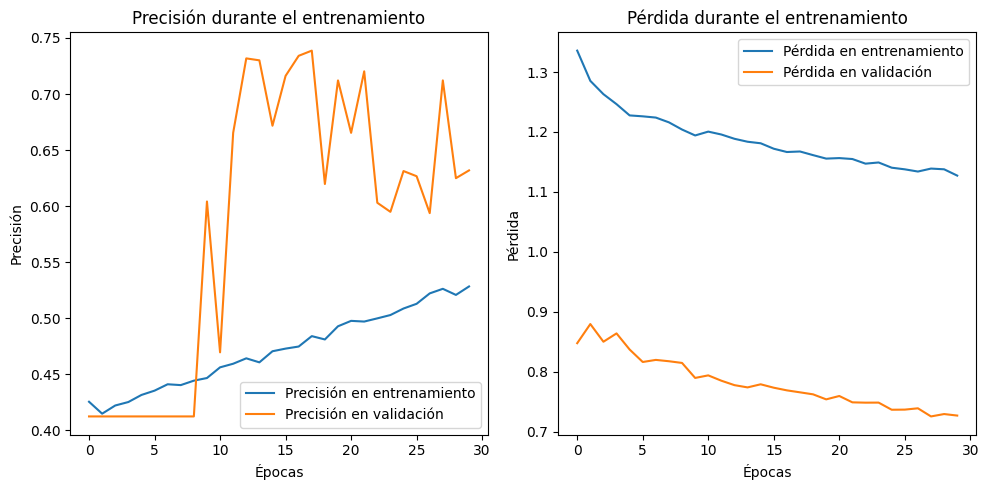

In [824]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [825]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


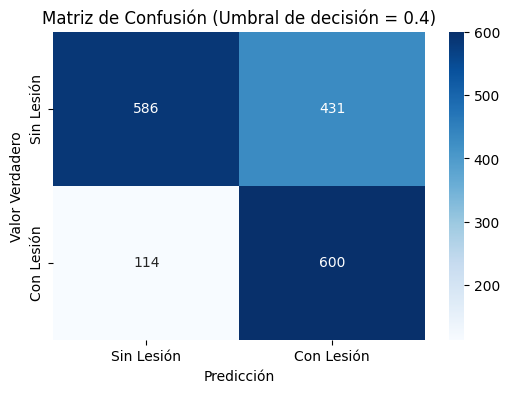

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [834]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


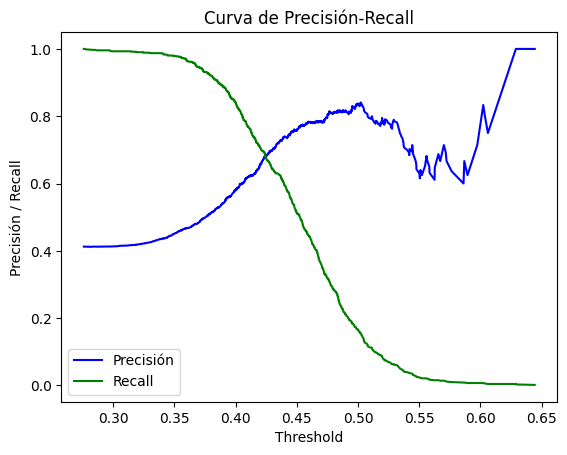

In [827]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

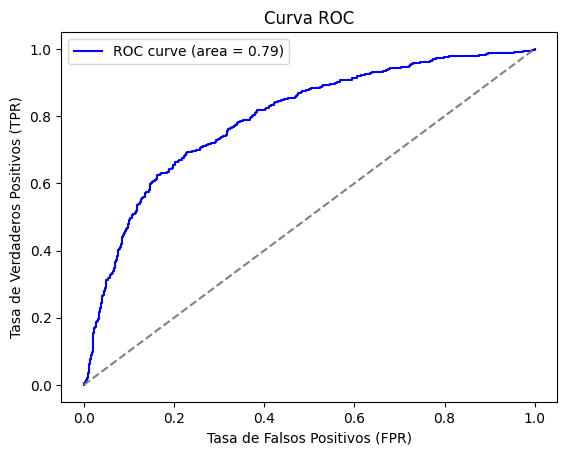

In [828]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [833]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [831]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558


### EfficientNetB7

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Cargar EfficientNetB0 preentrenado en ImageNet, sin la capa superior
base_model = EfficientNetB7(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# Congelar inicialmente todas las capas del modelo base
base_model.trainable = False

# Crear el modelo final con regularización L2 y Dropout para reducir el sobreajuste
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Usamos GlobalAveragePooling2D que es común para EfficientNet
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Regularización L2
    layers.Dropout(0.5),  # Dropout para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')  # Salida binaria
])

# Descongelar las últimas 10 capas del modelo base para ajuste fino (fine-tuning)
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Cambiar para descongelar solo las últimas 10 capas
    layer.trainable = False

# Callback para reducir la tasa de aprendizaje si la validación no mejora
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Early stopping para evitar sobreajuste y parar el entrenamiento temprano
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compilar el modelo con una tasa de aprendizaje más alta (y Adam como optimizador)
model.compile(optimizer=Adam(learning_rate=1e-4),  # Aumentar tasa de aprendizaje
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall'), 
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.AUC(name='f1_score')])  # Métricas añadidas

# Entrenar el modelo con callbacks
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping],  # Añadir EarlyStopping y ReduceLROnPlateau
    class_weight={0: 1., 1: 2.0}  # Ajustar class_weight para clases desbalanceadas
)

Epoch 1/10
171/253 [===================>..........] - ETA: 31s - loss: 1.1136 - accuracy: 0.4397 - precision: 0.4053 - recall: 0.7960 - auc: 0.4940 - f1_score: 0.4940

#### Evaluación

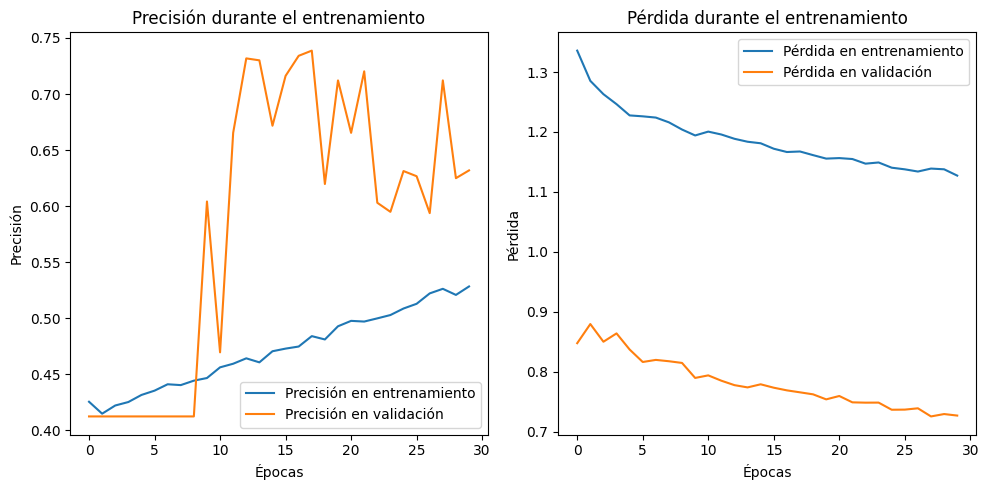

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida durante el entrenamiento
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 [==============================] - 3s 58ms/step - loss: 0.7291 - accuracy: 0.6424 - precision: 0.8369 - recall: 0.1653 - auc: 0.7936 - f1_score: 0.7936
Pérdida en el conjunto de prueba: 0.7291462421417236
accuracy en el conjunto de prueba: 0.642403244972229
Precision en el conjunto de prueba: 0.8368794322013855
Recall en el conjunto de prueba: 0.16526611149311066
AUC en el conjunto de prueba: 0.7935826182365417
F1-Score en el conjunto de prueba: 0.7935826182365417


**Matriz de confusión**

55/55 [==============================] - 3s 57ms/step


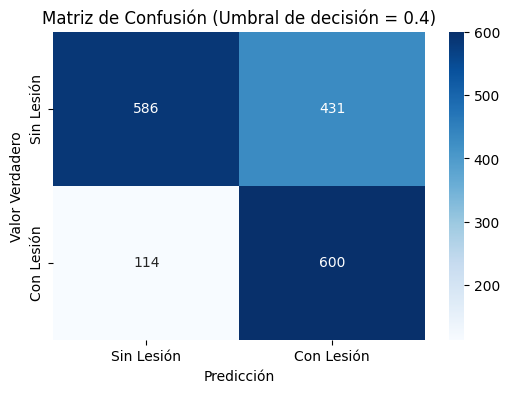

Recall (con umbral = 0.4): 0.8403361344537815
Precisión (con umbral = 0.4): 0.5819592628516004


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el nuevo umbral de decisión
threshold = 0.4  # Asegúrate de que este umbral es el mismo que en todos los cálculos

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred_proba = model.predict(test_generator)

# Convertir las probabilidades a etiquetas binarias con el umbral definido
y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)


# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes[:len(y_pred)]  # Asegúrate de que el tamaño coincida

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión usando seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sin Lesión', 'Con Lesión'], yticklabels=['Sin Lesión', 'Con Lesión'])
plt.title(f'Matriz de Confusión (Umbral de decisión = {threshold})')
plt.xlabel('Predicción')
plt.ylabel('Valor Verdadero')
plt.show()

# Calcular las métricas recall y precisión
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f'Recall (con umbral = {threshold}): {recall}')
print(f'Precisión (con umbral = {threshold}): {precision}')

55/55 [==============================] - 3s 57ms/step


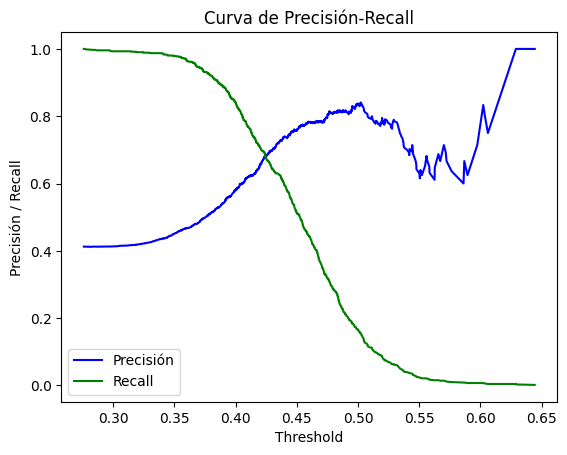

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)


# Obtener las etiquetas verdaderas
y_true = test_generator.classes[:len(y_pred_proba)]  # Asegúrate de que tengan el mismo tamaño

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

# Graficar la curva de precisión-recall
plt.plot(thresholds, precision[:-1], label="Precisión", color='b')
plt.plot(thresholds, recall[:-1], label="Recall", color='g')
plt.xlabel("Threshold")
plt.ylabel("Precisión / Recall")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

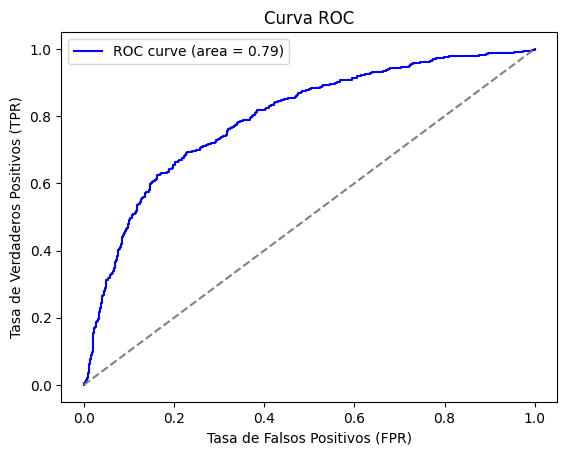

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calcular FPR, TPR y los umbrales
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Ajustar el umbral de decisión
new_threshold = 0.4
y_pred_class = (y_pred_prob >= new_threshold).astype(int)

# Recalcular métricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
auc_score = roc_auc_score(y_true, y_pred_prob)  # Usar probabilidades para AUC

print(f'Precisión: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC: {auc_score}')

Precisión: 0.8335607094133697
Recall: 0.8557422969187675
F1-Score: 0.8445058742225292
AUC: 0.9411709619934503


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Suponiendo que y_true contiene las etiquetas verdaderas (0 o 1) y y_pred_proba las probabilidades predichas
y_pred_proba = model.predict(test_generator)  # Asegúrate de obtener probabilidades
y_true = test_generator.classes  # Etiquetas verdaderas

# Verificar las dimensiones y el contenido
print(f"Dimensiones de y_pred_proba: {y_pred_proba.shape}")
print(f"Dimensiones de y_true: {y_true.shape}")

# Probar diferentes umbrales
f1_scores = []
thresholds = np.arange(0.0, 1.0, 0.01)

# Iterar sobre los diferentes umbrales
for threshold in thresholds:
    # Aplicar el umbral para convertir probabilidades en predicciones binarias
    # y_pred = (y_pred_proba > threshold).astype(int)
    # Por este fragmento
    y_pred = (y_pred_proba[:, 0] > threshold).astype(int)  # Asegúrate de usar [:, 0] si las predicciones son (n, 1)
    
    # Calcular el F1-score solo si las clases están bien distribuidas
    if len(np.unique(y_pred)) > 1:  # Asegurarse de que haya tanto 0s como 1s
        f1 = f1_score(y_true, y_pred)
        f1_scores.append(f1)
    else:
        f1_scores.append(0)  # Si todas las predicciones son iguales (todo 0 o todo 1)

# Encontrar el umbral con el mejor F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Mejor threshold para F1-score: {best_threshold}')
print(f'Mejor F1-score: {best_f1}')

# Dimensiones de y_pred_proba: (1731, 1)
# Dimensiones de y_true: (1731,)
# Mejor threshold para F1-score: 0.01
# Mejor F1-score: 0.5361904761904761

55/55 [==============================] - 3s 60ms/step
Dimensiones de y_pred_proba: (1731, 1)
Dimensiones de y_true: (1731,)
Mejor threshold para F1-score: 0.4
Mejor F1-score: 0.6876790830945558
